C:\Users\friha\AppData\Local\Temp\ipykernel_16052\693750642.py:13: DtypeWarning: Columns (19,68,72,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Successfully loaded the dataset.
Shape of the dataset: (49205, 79)

'has_worked' column created. Distribution:
has_worked
0    45523
1     3682
Name: count, dtype: int64

'ad_age_days' column created.

Encoded the following categorical columns: ['care_type', 'ad_status', 'ad_experienceAmount', 'ai_gender', 'ai_ethnic_origin', 'ai_environment']

Prepared final DataFrame for correlation analysis.
Shape of the correlation DataFrame: (49205, 135)

--- Correlation of Features with 'has_worked' ---
has_worked                                1.000000
user_grades_count                         0.355912
ad_age_days                               0.222342
ad_age_days                               0.222342
user_isVerified                           0.202408
                                            ...   
ai_age_confidence                        -0.033289
user_grades_average                      -0.066761
ad_experienceAmount_LESS_THAN_ONE_YEAR   -0.072303
care_type_seniorcare                     -0

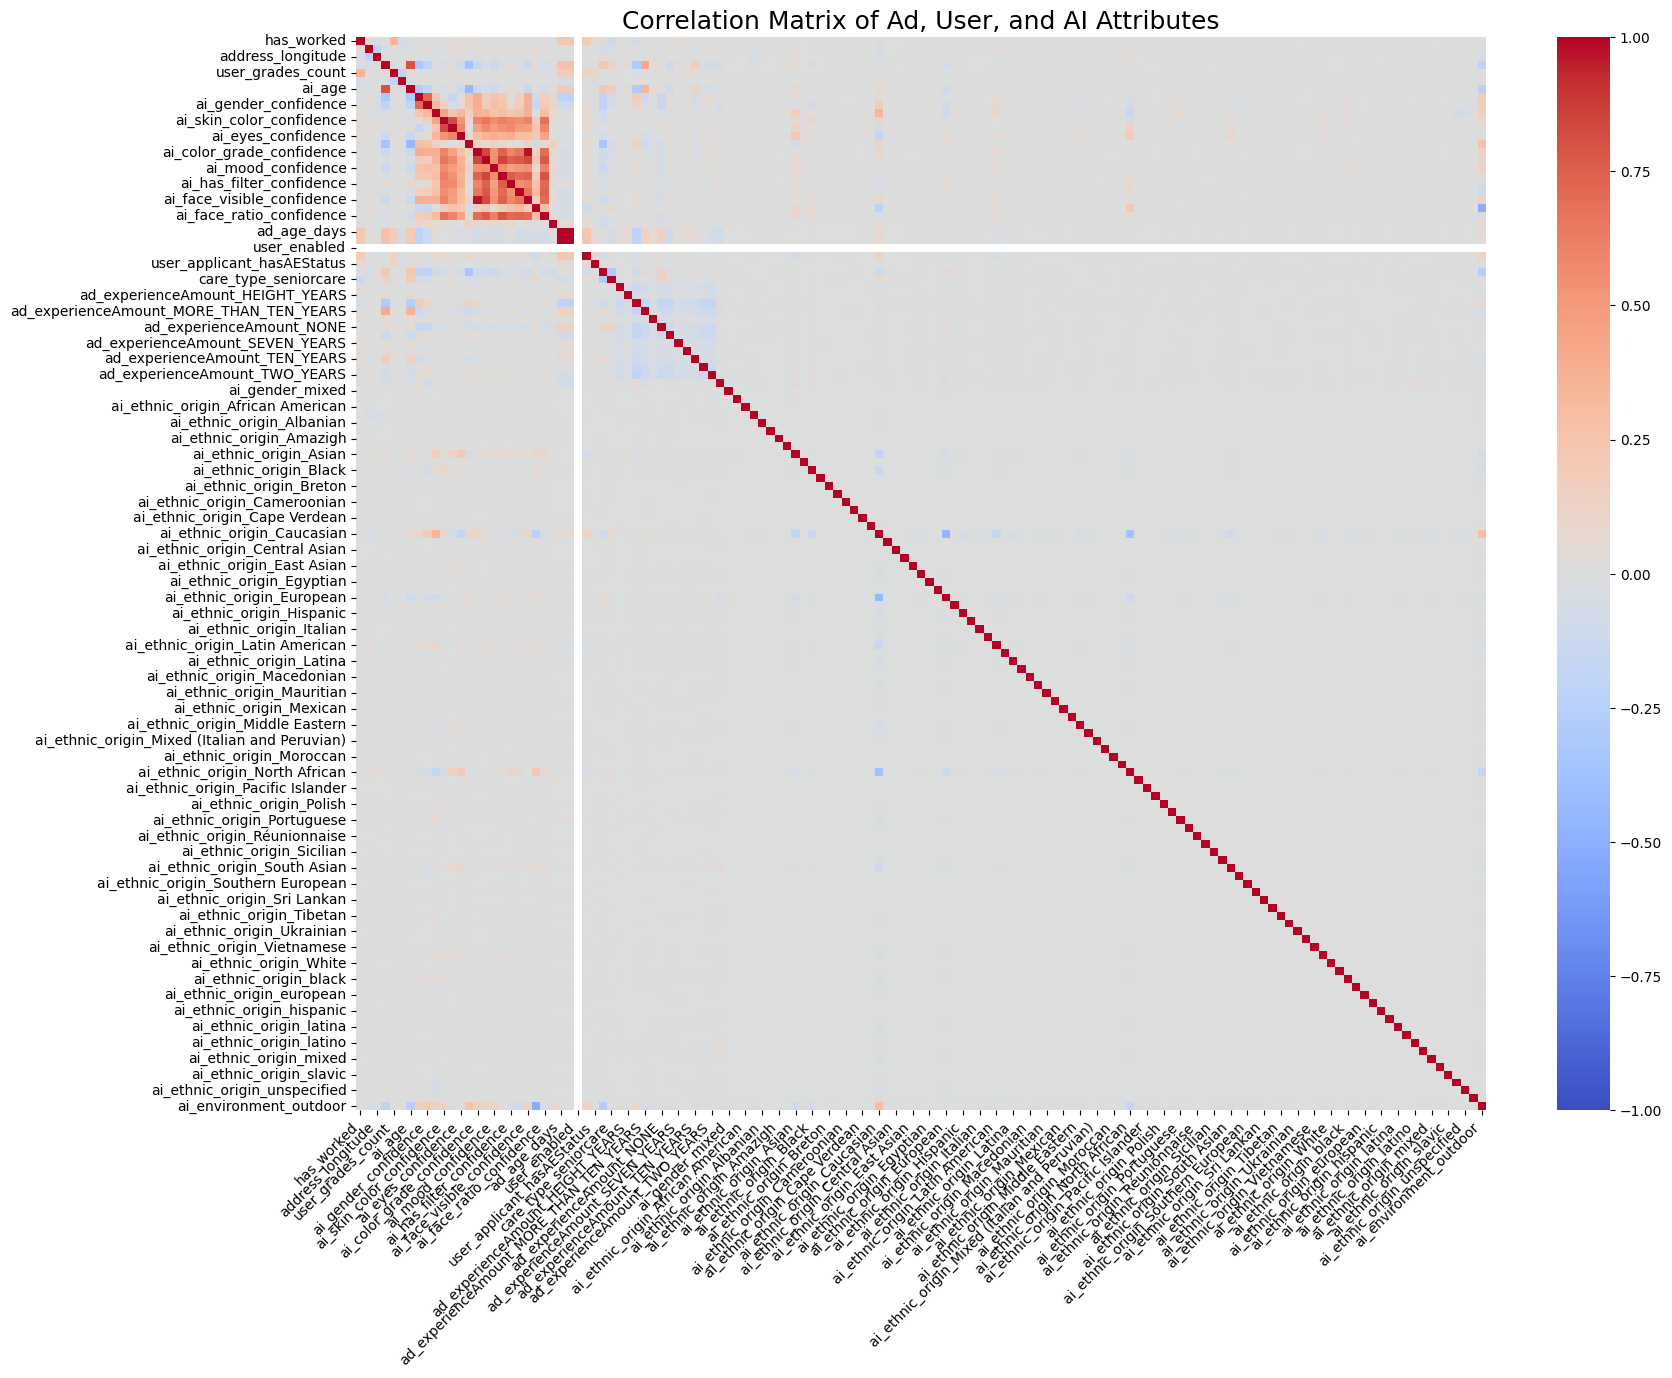

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load and Prepare the Data ---

## USER ACTION REQUIRED:
# Update the file_path to the correct location of your CSV file.
file_path = 'D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed_mistral-medium-latest_with_ai.csv'

try:
    df = pd.read_csv(file_path)
    print("Successfully loaded the dataset.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at '{file_path}'. Please check the path and try again.")
    df = pd.DataFrame()

if not df.empty:
    # --- 2. Feature Engineering & Preprocessing ---
    if 'badges_json' in df.columns:
        df['has_worked'] = df['badges_json'].str.contains('"TYPE_WORKED_HOURS"', na=False).astype(int)
        print("\n'has_worked' column created. Distribution:")
        print(df['has_worked'].value_counts())
    else:
        print("\nWarning: 'badges_json' column not found. 'has_worked' column cannot be created.")
        df['has_worked'] = 0
    if 'ad_createdAt' in df.columns:
        df['ad_createdAt'] = pd.to_datetime(df['ad_createdAt'], errors='coerce')
        df['ad_age_days'] = (pd.Timestamp.now() - df['ad_createdAt']).dt.days
        print("\n'ad_age_days' column created.")

    df_for_corr = pd.DataFrame()
    df_for_corr['has_worked'] = df['has_worked'] # Add our target variable

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # --- THIS IS THE CORRECTED LINE ---
    # Add 'has_worked' to the exclusion list to prevent it from being added twice.
    cols_to_exclude = ['ad_id', 'user_id', 'postal_code', 'address_zipCode', 'has_worked']
    # --- END OF CORRECTION ---

    final_numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]
    if 'ad_age_days' in df.columns: final_numeric_cols.append('ad_age_days')

    df_for_corr = pd.concat([df_for_corr, df[final_numeric_cols]], axis=1)

    bool_cols = df.select_dtypes(include='bool').columns.tolist()
    for col in bool_cols: df_for_corr[col] = df[col].astype(int)
    
    categorical_cols_to_encode = ['care_type', 'ad_status', 'ad_experienceAmount', 'ai_gender', 'ai_ethnic_origin', 'ai_environment']
    existing_categorical_cols = [col for col in categorical_cols_to_encode if col in df.columns]
    if existing_categorical_cols:
        df_encoded = pd.get_dummies(df[existing_categorical_cols], prefix=existing_categorical_cols, drop_first=True, dtype=int)
        df_for_corr = pd.concat([df_for_corr, df_encoded], axis=1)
        print(f"\nEncoded the following categorical columns: {existing_categorical_cols}")
    
    df_for_corr.dropna(axis=1, how='all', inplace=True)
    df_for_corr.fillna(df_for_corr.median(), inplace=True)
    print("\nPrepared final DataFrame for correlation analysis.")
    print(f"Shape of the correlation DataFrame: {df_for_corr.shape}")


    # --- 3. Calculate and Print Correlation with 'has_worked' ---
    if not df_for_corr.empty and 'has_worked' in df_for_corr.columns:
        try:
            corr_matrix = df_for_corr.corr()
            corr_with_target = corr_matrix.sort_values(by='has_worked', ascending=False)['has_worked']

            print("\n" + "="*50)
            print("--- Correlation of Features with 'has_worked' ---")
            print("="*50)
            print(corr_with_target)

            # --- 4. Visualize the Correlation Matrix ---
            print("\nGenerating correlation heatmap...")
            plt.figure(figsize=(18, 14))
            sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
            plt.title('Correlation Matrix of Ad, User, and AI Attributes', fontsize=18)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout(pad=1.5)
            plt.show()

        except Exception as e:
            print(f"\nAn error occurred during correlation or plotting: {e}")
    else:
        print("\nCould not calculate correlation. The processed DataFrame is empty or missing 'has_worked'.")

Analysis 1: Top Positive and Negative Correlated Features


C:\Users\friha\AppData\Local\Temp\ipykernel_16052\2823919744.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_positive.values, y=top_positive.index, ax=axes[0], palette='viridis')
C:\Users\friha\AppData\Local\Temp\ipykernel_16052\2823919744.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_negative.values, y=top_negative.index, ax=axes[1], palette='plasma')


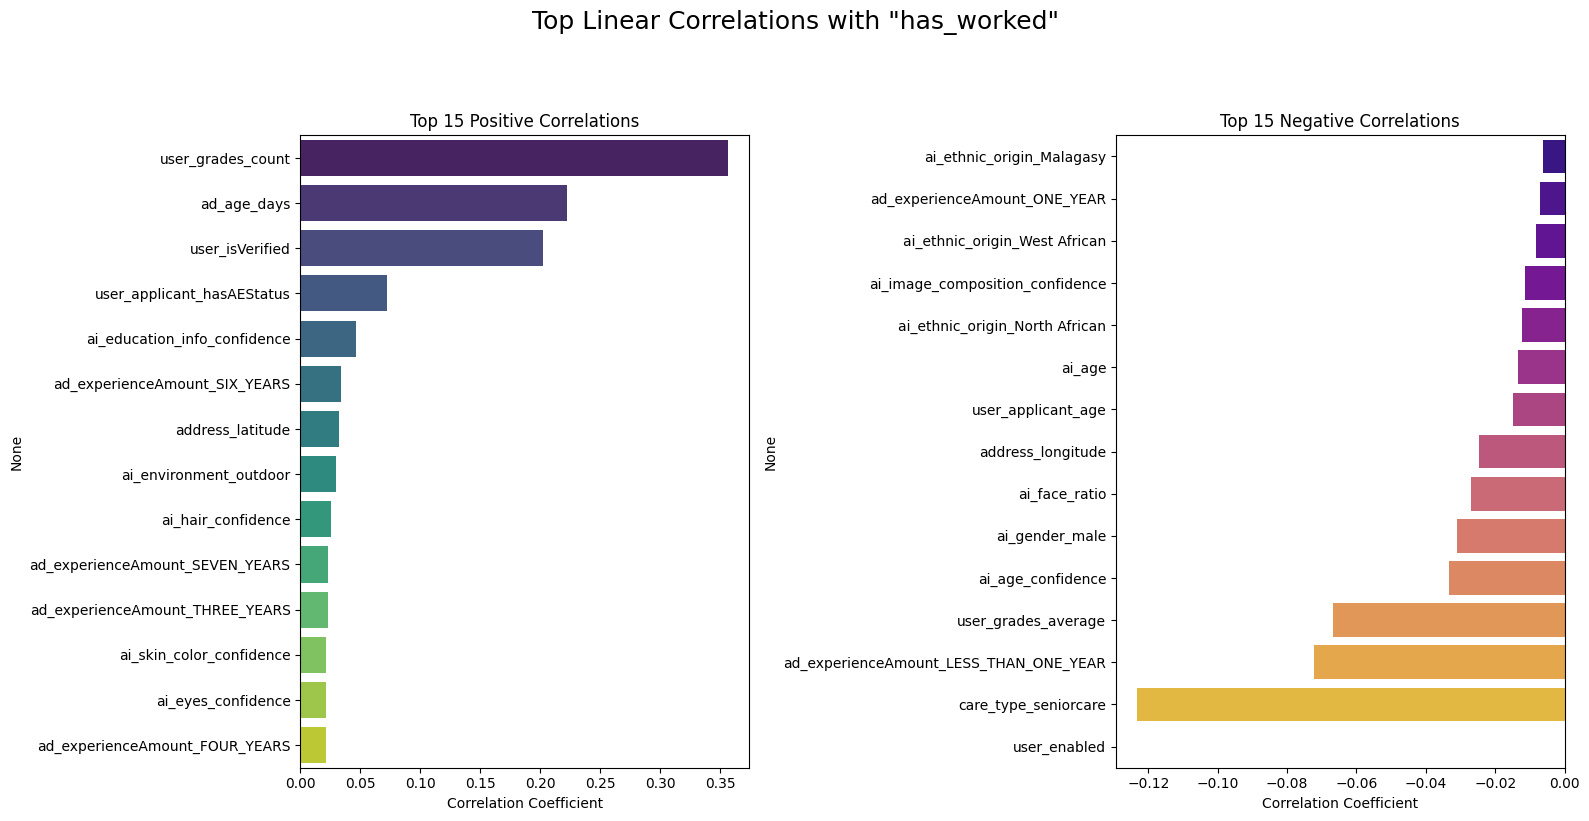


Analysis 2: Deep Dive on 'ad_experienceAmount'
Work Rate by Experience Level:
                     Work Rate (%)  Number of Ads
ad_experienceAmount                              
SIX_YEARS                12.524851           1509
SEVEN_YEARS              11.462094           1108
NINE_YEARS               10.961969            447
FIVE_YEARS                9.800469           3408
FOUR_YEARS                9.793814           2716
THREE_YEARS               9.360035           4594
TEN_YEARS                 8.615100           2159
TWO_YEARS                 7.801297           5858
HEIGHT_YEARS              7.659574            940
MORE_THAN_TEN_YEARS       7.583617           5591
NONE                      7.424416           5226
ONE_YEAR                  6.940973           5201
LESS_THAN_ONE_YEAR        3.818913          10448


C:\Users\friha\AppData\Local\Temp\ipykernel_16052\2823919744.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=experience_analysis.index, y=experience_analysis['Work Rate (%)'], order=experience_analysis.index, palette='crest')
C:\Users\friha\AppData\Local\Temp\ipykernel_16052\2823919744.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


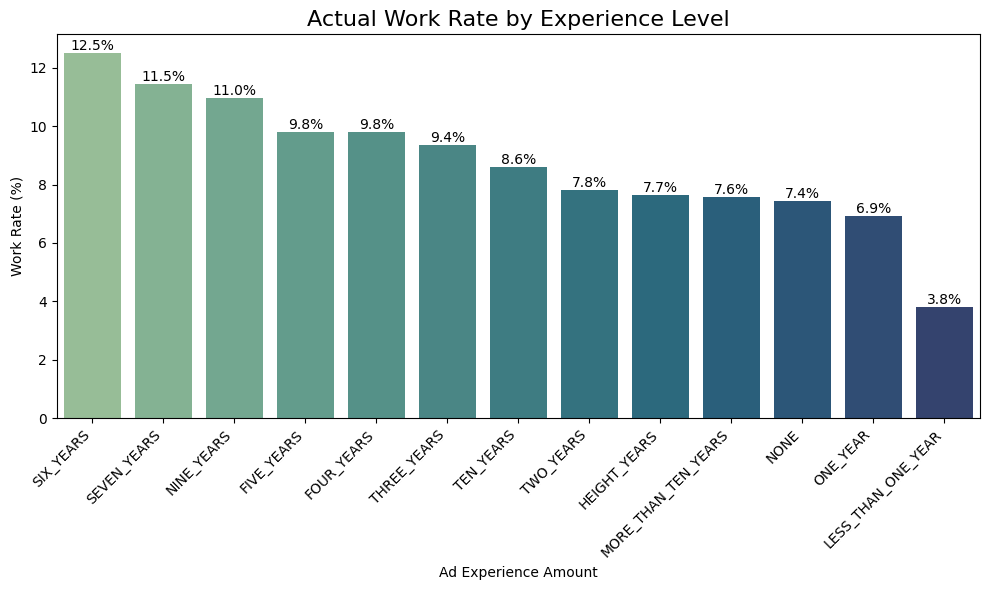


Analysis 3: Feature Importance from a Predictive Model
Training a Random Forest model to see which features are most predictive when combined.

Top 25 Most Important Features According to Random Forest:
user_grades_count                  0.150645
ad_age_days                        0.093660
ad_age_days                        0.090967
address_longitude                  0.075968
address_latitude                   0.075132
user_applicant_age                 0.061327
ai_age                             0.043673
user_isVerified                    0.028816
care_type_seniorcare               0.025487
ai_face_ratio                      0.021126
ai_mood_confidence                 0.019930
ai_ethnic_origin_confidence        0.019812
ai_image_composition_confidence    0.017224
ai_education_info_confidence       0.016927
ai_eyes_confidence                 0.015964
ai_has_filter_confidence           0.015187
user_grades_average                0.013488
ai_hair_confidence                 0.013274
care

C:\Users\friha\AppData\Local\Temp\ipykernel_16052\2823919744.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_25_features.values, y=top_25_features.index, palette='mako')


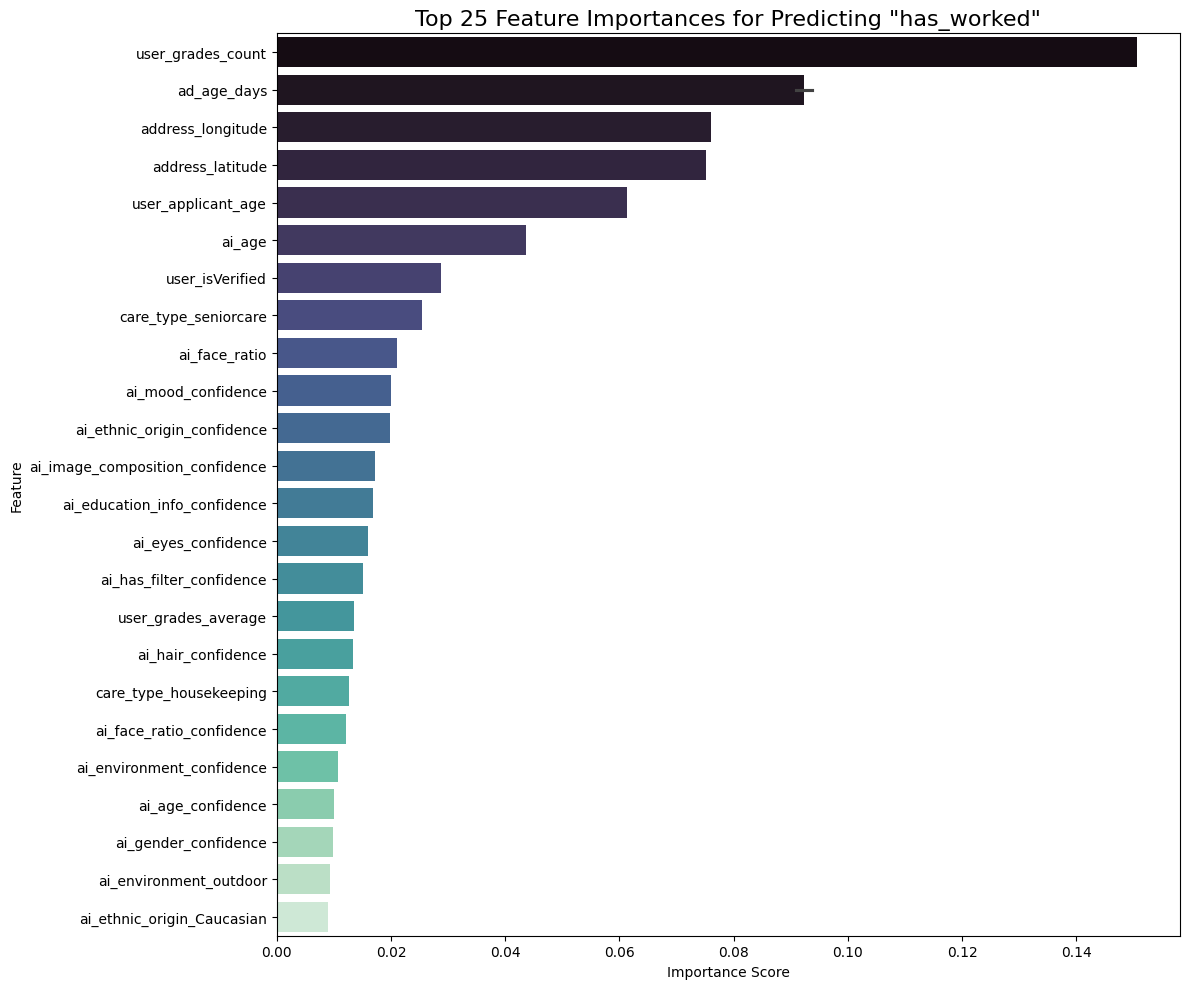

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# This cell assumes that 'df', 'df_for_corr', and 'corr_with_target'
# from the previous cell are available in your notebook's memory.

print("="*60)
print("Analysis 1: Top Positive and Negative Correlated Features")
print("="*60)

# Remove the perfect self-correlation of 'has_worked'
corr_with_target_filtered = corr_with_target.drop('has_worked')

# Get the top 15 positive and top 15 negative correlations
top_positive = corr_with_target_filtered.head(15)
top_negative = corr_with_target_filtered.tail(15).sort_values(ascending=False) # sort for plotting

# Create subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Top Linear Correlations with "has_worked"', fontsize=18, y=1.02)

# Plot Top Positive Correlations
sns.barplot(x=top_positive.values, y=top_positive.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 15 Positive Correlations')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_xlim(left=0) # Start x-axis at 0 for positive correlations

# Plot Top Negative Correlations
sns.barplot(x=top_negative.values, y=top_negative.index, ax=axes[1], palette='plasma')
axes[1].set_title('Top 15 Negative Correlations')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_xlim(right=0) # End x-axis at 0 for negative correlations

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


print("\n" + "="*60)
print("Analysis 2: Deep Dive on 'ad_experienceAmount'")
print("="*60)
# Use the original 'df' to get the actual work rate per experience category

if 'ad_experienceAmount' in df.columns:
    # Group by the original experience category and calculate the mean of 'has_worked' (which is the work rate)
    # also get the count to see the sample size for each category
    experience_analysis = df.groupby('ad_experienceAmount')['has_worked'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
    experience_analysis.rename(columns={'mean': 'Work Rate (%)', 'count': 'Number of Ads'}, inplace=True)
    experience_analysis['Work Rate (%)'] = experience_analysis['Work Rate (%)'] * 100 # Convert to percentage

    print("Work Rate by Experience Level:")
    print(experience_analysis)

    # Visualize the work rate
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=experience_analysis.index, y=experience_analysis['Work Rate (%)'], order=experience_analysis.index, palette='crest')
    ax.set_title('Actual Work Rate by Experience Level', fontsize=16)
    ax.set_xlabel('Ad Experience Amount')
    ax.set_ylabel('Work Rate (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # Add percentage labels on top of bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.tight_layout()
    plt.show()
else:
    print("'ad_experienceAmount' column not found in the original DataFrame.")


print("\n" + "="*60)
print("Analysis 3: Feature Importance from a Predictive Model")
print("="*60)
print("Training a Random Forest model to see which features are most predictive when combined.")

# Prepare data for the model
# X contains all the features (predictors)
X = df_for_corr.drop('has_worked', axis=1)
# y contains only the target variable
y = df_for_corr['has_worked']

# Ensure all column names are strings (required by some versions of scikit-learn)
X.columns = X.columns.astype(str)

# Initialize and train the Random Forest model
# n_jobs=-1 uses all available CPU cores to speed up training.
# random_state=42 ensures the results are reproducible.
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# Get feature importances from the trained model
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_25_features = importances.head(25)

print("\nTop 25 Most Important Features According to Random Forest:")
print(top_25_features)

# Visualize the feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=top_25_features.values, y=top_25_features.index, palette='mako')
plt.title('Top 25 Feature Importances for Predicting "has_worked"', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

--- 1. Loading and Preparing Data ---


C:\Users\friha\AppData\Local\Temp\ipykernel_3820\3938695525.py:28: DtypeWarning: Columns (19,68,72,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flat = pd.read_csv('D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed_mistral-medium-latest_with_ai.csv')


Loaded 37587 users and 49205 flattened ads.

'has_worked' flag created for each user.
has_worked
0    0.923
1    0.077
Name: proportion, dtype: float64

Created primary ad profiles for 37587 users.
Created final analysis DataFrame with 37587 users with primary ad data.

Data preparation complete.


Analysis 2: Work Rate by Care Category
              User_Count  Work_Rate_Percent
care_type                                  
childcare          20319               9.11
housekeeping       13491               6.83
seniorcare          3777               3.71


C:\Users\friha\AppData\Local\Temp\ipykernel_3820\3938695525.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=care_type_analysis.index, y=care_type_analysis['Work_Rate_Percent'], palette='viridis')


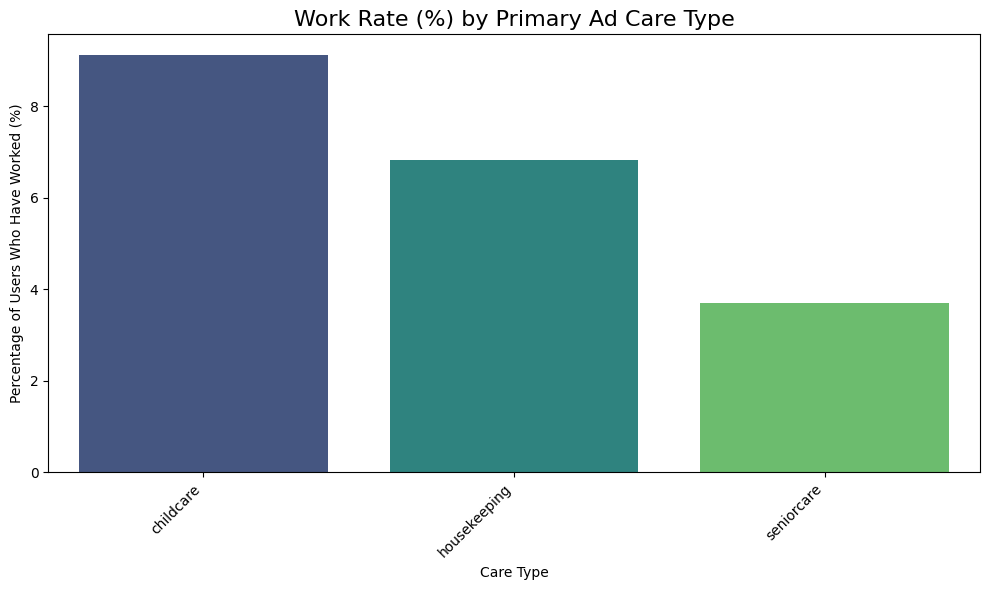

C:\Users\friha\AppData\Local\Temp\ipykernel_3820\3938695525.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=care_type_analysis.index, y=care_type_analysis['Work_Rate_Percent'], palette='viridis')




Analysis 2: Work Rate by Care Category
              Ad_Count  Work_Rate_Percent
care_type                                
childcare        24439               9.52
housekeeping     16998               7.98
seniorcare        7768               0.00


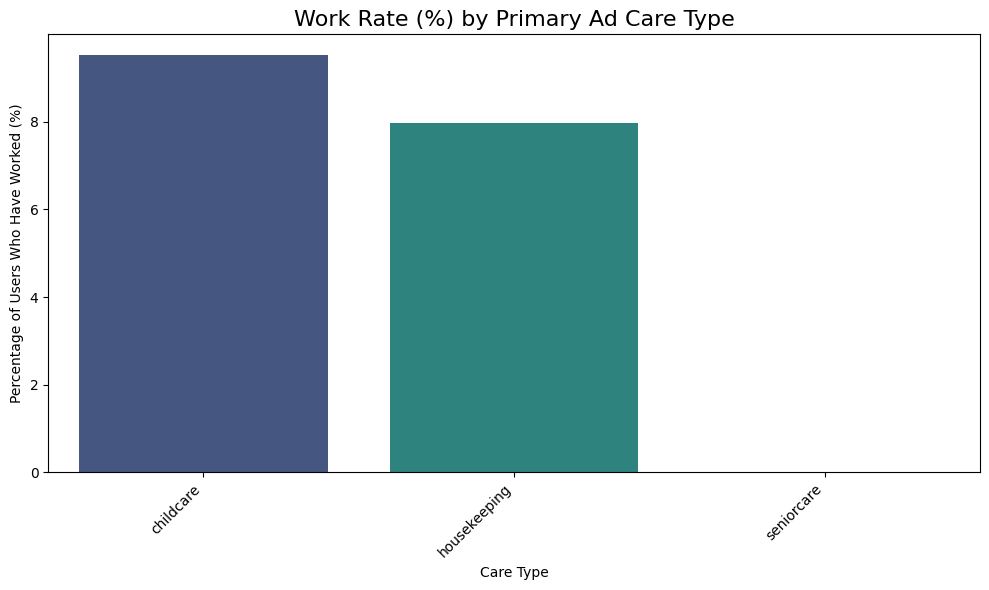



Analysis 3: Work Rate in Paris vs. Marseille
              User_Count  Work_Rate_Percent
address_city                               
Paris               3115              12.62
Marseille            543               7.92


C:\Users\friha\AppData\Local\Temp\ipykernel_3820\3938695525.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_analysis.index, y=city_analysis['Work_Rate_Percent'], palette='coolwarm')


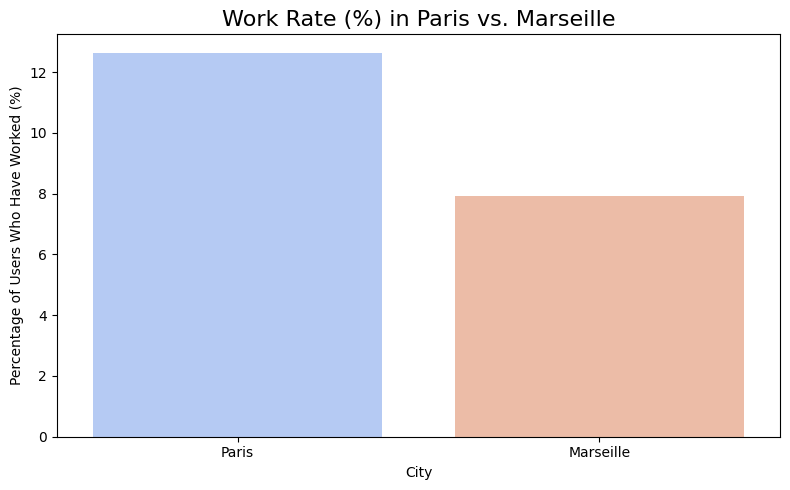



Analysis 4: Work Rate by Year of Ad Creation
                  User_Count  Work_Rate_Percent
ad_creation_year                               
2013                     143              17.48
2014                     150              10.00
2015                     252              20.24
2016                     534              19.10
2017                     875              24.80
2018                    1140              23.16
2019                    1347              20.12
2020                    1669              18.33
2021                    3700              10.22
2022                    3910              10.72
2023                    4262              10.11
2024                   12536               3.02
2025                    7054               0.77


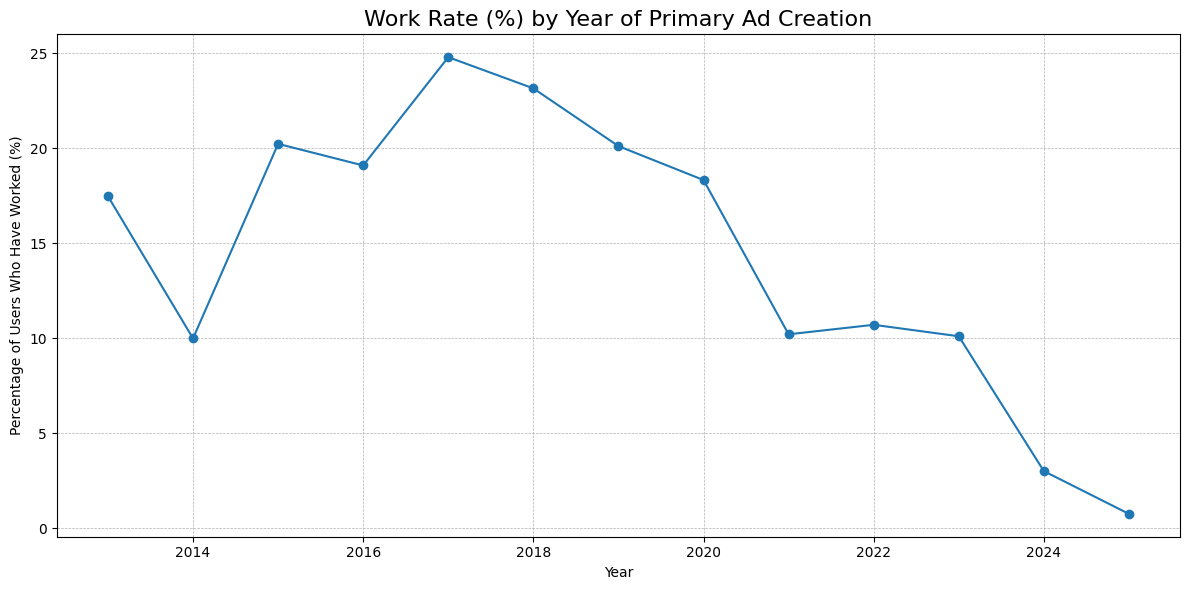


--- Subset Analysis for Ads Created in 2024 ---
Total Users with primary ad created in 2024: 12536
Overall Work Rate for 2024 cohort: 3.02%


Analysis 5: Correlation between Work Rate and Distance from Paris
Correlation between 'distance_from_paris_km' and 'has_worked': -0.0447
(For users within 100km of Paris center)


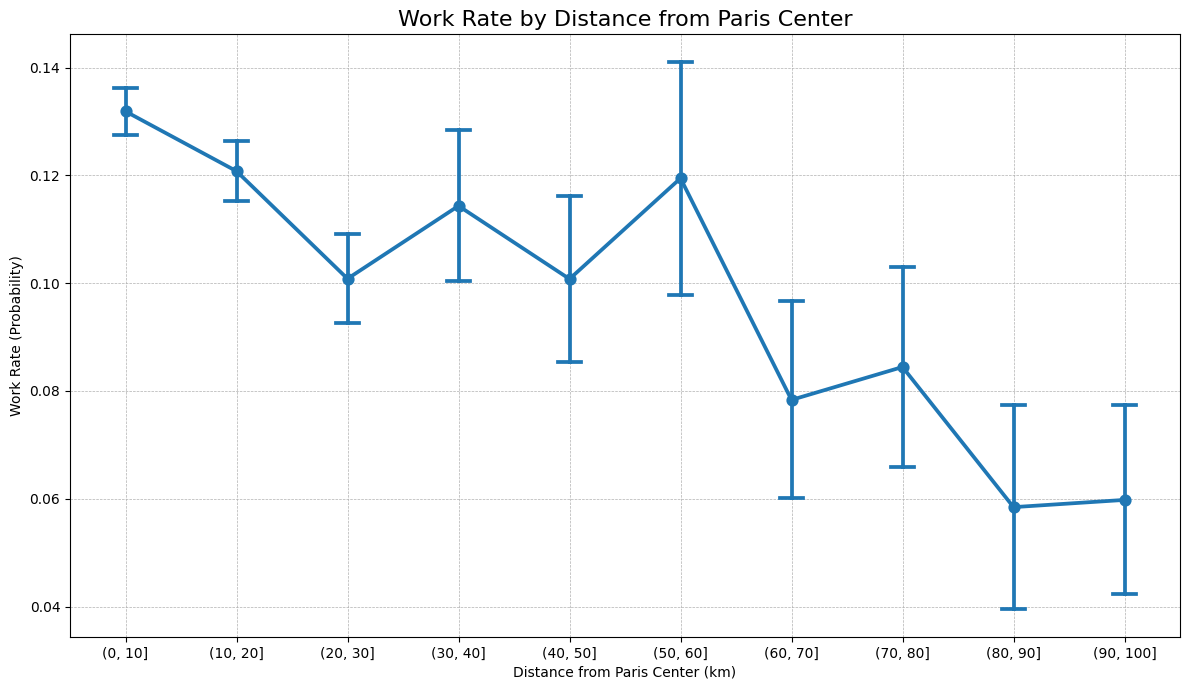

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# --- Configuration & Helper Functions ---

# Set display options for pandas DataFrames
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 120)

# Define center of Paris for distance calculation
PARIS_CENTER_COORDS = (48.8566, 2.3522) # Approx. center of Paris

def calculate_distance_from_paris(row):
    """Calculates geodesic distance from Paris center if coordinates are valid."""
    if pd.notna(row['address_latitude']) and pd.notna(row['address_longitude']):
        return geodesic(PARIS_CENTER_COORDS, (row['address_latitude'], row['address_longitude'])).kilometers
    return np.nan

# --- 1. Data Loading and Preparation ---
print("--- 1. Loading and Preparing Data ---")
try:
    # Load all the datasets
    df_users = pd.read_csv('D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/users_processed.csv')
    df_badges = pd.read_csv('D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/ad_badges_processed.csv')
    df_flat = pd.read_csv('D:/Data Extraction FSP/Yoopies-fr/preprocessed_data/yoopies/flattened_ads_processed_mistral-medium-latest_with_ai.csv')

    # Ensure key columns are of the correct type
    df_flat['ad_id'] = pd.to_numeric(df_flat['ad_id'], errors='coerce')
    df_flat['user_id'] = pd.to_numeric(df_flat['user_id'], errors='coerce')
    df_flat['ad_updatedAt'] = pd.to_datetime(df_flat['ad_updatedAt'], errors='coerce')
    df_flat.dropna(subset=['ad_id', 'user_id', 'ad_updatedAt'], inplace=True)
    print(f"Loaded {len(df_users)} users and {len(df_flat)} flattened ads.")

    worked_ad_ids = set(df_badges[df_badges['badge_name'] == 'TYPE_WORKED_HOURS']['ad_id'].unique())
    df_flat['ad_has_worked'] = df_flat['ad_id'].isin(worked_ad_ids).astype(int)
    user_work_status = df_flat.groupby('user_id')['ad_has_worked'].max().rename('has_worked')
    df_users = df_users.merge(user_work_status, on='user_id', how='left')
    df_users['has_worked'].fillna(0, inplace=True)
    df_users['has_worked'] = df_users['has_worked'].astype(int)
    print("\n'has_worked' flag created for each user.")
    print(df_users['has_worked'].value_counts(normalize=True).round(3))

    df_primary_ad = df_flat.sort_values('ad_updatedAt').drop_duplicates('user_id', keep='last')
    print(f"\nCreated primary ad profiles for {len(df_primary_ad)} users.")
    
    cols_to_merge = ['user_id', 'ad_createdAt', 'care_type', 'address_city', 'address_latitude', 'address_longitude']
    existing_cols_to_merge = [col for col in cols_to_merge if col in df_primary_ad.columns]
    
    df_analysis = df_users.merge(df_primary_ad[existing_cols_to_merge], on='user_id', how='inner')
    df_analysis['ad_createdAt'] = pd.to_datetime(df_analysis['ad_createdAt'], errors='coerce')
    df_analysis['ad_creation_year'] = df_analysis['ad_createdAt'].dt.year
    print(f"Created final analysis DataFrame with {len(df_analysis)} users with primary ad data.")
    print("\nData preparation complete.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all CSV files are in the same directory as the notebook.")
    df_analysis = pd.DataFrame()

# --- Run Analyses only if data preparation was successful ---
if not df_analysis.empty:

    # --- 2. Analysis on Care Categories ---
    print("\n\n" + "="*60)
    print("Analysis 2: Work Rate by Care Category")
    print("="*60)
    if 'care_type' in df_analysis.columns:
        # --- CORRECTED SYNTAX ---
        care_type_analysis = df_analysis.groupby('care_type')['has_worked'].agg(
            User_Count='count',
            Work_Rate_Percent=lambda x: x.mean() * 100
        ).sort_values(by='Work_Rate_Percent', ascending=False)
        
        print(care_type_analysis.round(2))

        # Visualization
        plt.figure(figsize=(10, 6))
        sns.barplot(x=care_type_analysis.index, y=care_type_analysis['Work_Rate_Percent'], palette='viridis')
        plt.title('Work Rate (%) by Primary Ad Care Type', fontsize=16)
        plt.xlabel('Care Type')
        plt.ylabel('Percentage of Users Who Have Worked (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("'care_type' column not found.")


    # --- 2.1. Analysis on Care Categories ---
    print("\n\n" + "="*60)
    print("Analysis 2: Work Rate by Care Category")
    print("="*60)
    if 'care_type' in df_flat.columns: #df_analysis.columns:
        # --- CORRECTED SYNTAX ---
        care_type_analysis = df_flat.groupby('care_type')['ad_has_worked'].agg( 
            Ad_Count='count',
            Work_Rate_Percent=lambda x: x.mean() * 100
        ).sort_values(by='Work_Rate_Percent', ascending=False)
        
        print(care_type_analysis.round(2))

        # Visualization
        plt.figure(figsize=(10, 6))
        sns.barplot(x=care_type_analysis.index, y=care_type_analysis['Work_Rate_Percent'], palette='viridis')
        plt.title('Work Rate (%) by Primary Ad Care Type', fontsize=16)
        plt.xlabel('Care Type')
        plt.ylabel('Percentage of Users Who Have Worked (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("'care_type' column not found.")

    # --- 3. Analysis on Geolocation Zones (Paris vs. Marseille) ---
    print("\n\n" + "="*60)
    print("Analysis 3: Work Rate in Paris vs. Marseille")
    print("="*60)
    if 'address_city' in df_analysis.columns:
        cities_to_analyze = ['Paris', 'Marseille']
        df_cities = df_analysis[df_analysis['address_city'].isin(cities_to_analyze)]
        if not df_cities.empty:
            # --- CORRECTED SYNTAX ---
            city_analysis = df_cities.groupby('address_city')['has_worked'].agg(
                User_Count='count',
                Work_Rate_Percent=lambda x: x.mean() * 100
            ).reindex(cities_to_analyze)

            print(city_analysis.round(2))

            # Visualization
            plt.figure(figsize=(8, 5))
            sns.barplot(x=city_analysis.index, y=city_analysis['Work_Rate_Percent'], palette='coolwarm')
            plt.title('Work Rate (%) in Paris vs. Marseille', fontsize=16)
            plt.xlabel('City')
            plt.ylabel('Percentage of Users Who Have Worked (%)')
            plt.tight_layout()
            plt.show()
        else:
            print("No users found in Paris or Marseille in the dataset.")
    else:
        print("'address_city' column not found.")

    # --- 4. Analysis by Year of Ad Creation ---
    print("\n\n" + "="*60)
    print("Analysis 4: Work Rate by Year of Ad Creation")
    print("="*60)
    if 'ad_creation_year' in df_analysis.columns:
        year_counts = df_analysis['ad_creation_year'].value_counts()
        valid_years = year_counts[year_counts > 50].index
        df_years = df_analysis[df_analysis['ad_creation_year'].isin(valid_years)]

        # --- CORRECTED SYNTAX ---
        year_analysis = df_years.groupby('ad_creation_year')['has_worked'].agg(
            User_Count='count',
            Work_Rate_Percent=lambda x: x.mean() * 100
        ).sort_index()

        print(year_analysis.round(2))

        # Visualization
        plt.figure(figsize=(12, 6))
        ax = year_analysis['Work_Rate_Percent'].plot(kind='line', marker='o', linestyle='-')
        plt.title('Work Rate (%) by Year of Primary Ad Creation', fontsize=16)
        plt.xlabel('Year')
        plt.ylabel('Percentage of Users Who Have Worked (%)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        
        print("\n--- Subset Analysis for Ads Created in 2024 ---")
        df_2024 = df_analysis[df_analysis['ad_creation_year'] == 2024]
        if not df_2024.empty:
            work_rate_2024 = df_2024['has_worked'].mean() * 100
            print(f"Total Users with primary ad created in 2024: {len(df_2024)}")
            print(f"Overall Work Rate for 2024 cohort: {work_rate_2024:.2f}%")
        else:
            print("No data found for ads created in 2024.")
    else:
        print("'ad_creation_year' column not found.")

    # --- 5. Geolocation Correlation (Distance from Paris Center) ---
    print("\n\n" + "="*60)
    print("Analysis 5: Correlation between Work Rate and Distance from Paris")
    print("="*60)
    if 'address_latitude' in df_analysis.columns and 'address_longitude' in df_analysis.columns:
        df_analysis['distance_from_paris_km'] = df_analysis.apply(calculate_distance_from_paris, axis=1)
        df_geo = df_analysis.dropna(subset=['distance_from_paris_km', 'has_worked'])
        df_geo = df_geo[df_geo['distance_from_paris_km'] <= 100]
        if not df_geo.empty:
            correlation = df_geo[['distance_from_paris_km', 'has_worked']].corr().iloc[0, 1]
            print(f"Correlation between 'distance_from_paris_km' and 'has_worked': {correlation:.4f}")
            print("(For users within 100km of Paris center)")

            df_geo['distance_bin'] = pd.cut(df_geo['distance_from_paris_km'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
            plt.figure(figsize=(12, 7))
            sns.pointplot(x='distance_bin', y='has_worked', data=df_geo, errorbar='se', capsize=.2)
            plt.title('Work Rate by Distance from Paris Center', fontsize=16)
            plt.xlabel('Distance from Paris Center (km)')
            plt.ylabel('Work Rate (Probability)')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough data within 100km of Paris to perform correlation analysis.")
    else:
        print("'address_latitude' or 'address_longitude' columns not found.")

In [9]:
%pip install pandas numpy seaborn matplotlib geopy scikit-learn lightgbm shap

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'c:\\Python311\\Scripts\\numba'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.5 MB 3.6 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.5 MB 3.2 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.5 MB 3.0 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.5 MB 3.0 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.5 MB 2.9 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.5 MB 3.0 MB/s eta 0:00:01
   ------------------------- -------------- 0.9/1.5 MB 3.0 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.5 MB 2.9 MB/s eta 0:00:01
   ------------------------------- -------- 1.1/1.5 MB 2.7 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 2.8 MB/s eta 0:00:01
   -------------------------------------- - 1.4/1.5 MB 2.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.7 MB/s eta 0:00:00
   ---------------

### 1 - Data loading

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import json
import os
import warnings

# --- Machine Learning Imports ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# --- Configuration ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 180)

# Define file path and Paris coordinates
DATA_DIR = './preprocessed_data/yoopies/'
PARIS_CENTER_COORDS = (48.8566, 2.3522)

# --- Helper Functions ---
def calculate_distance_from_paris(row):
    lat, lon = row.get('address_latitude'), row.get('address_longitude')
    if pd.notna(lat) and pd.notna(lon):
        return geodesic(PARIS_CENTER_COORDS, (lat, lon)).kilometers
    return np.nan

# --- Data Loading ---
print("--- 1. Loading All Datasets ---")
try:
    df_users = pd.read_csv(os.path.join(DATA_DIR, 'users_processed.csv'))
    df_badges = pd.read_csv(os.path.join(DATA_DIR, 'ad_badges_processed.csv'))
    df_flat = pd.read_csv(os.path.join(DATA_DIR, 'flattened_ads_processed_mistral-medium-latest_with_ai.csv'), low_memory=False)
    df_categories = pd.read_csv(os.path.join(DATA_DIR, 'ad_categories_processed.csv'))
    df_languages = pd.read_csv(os.path.join(DATA_DIR, 'ad_languages_processed.csv'))
    df_rates = pd.read_csv(os.path.join(DATA_DIR, 'ad_rates_processed.csv'))
    df_tags = pd.read_csv(os.path.join(DATA_DIR, 'ad_tags_processed.csv'))
    df_hobbies = pd.read_csv(os.path.join(DATA_DIR, 'hobbies_mistral-medium-latest.csv'))
    df_qualities = pd.read_csv(os.path.join(DATA_DIR, 'personal_qualities_mistral-medium-latest.csv'))
    
    print("All CSV files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all CSV files are in './preprocessed_data/yoopies/'.")
    # Terminate script execution if files are missing
    raise e

--- 1. Loading All Datasets ---
All CSV files loaded successfully.


### 2 -Feature Engineering (The Foundation)

In [15]:
print("\n--- 2. Feature Engineering ---")

# --- a) Ad-Level Feature Creation ---
print("  Creating ad-level features...")
# Start with the rich flattened file
df_ads_master = df_flat.copy()

# Create ad-level target variables
df_worked_hours = df_badges[df_badges['badge_name'] == 'TYPE_WORKED_HOURS'].copy()
df_worked_hours['ad_worked_hours'] = pd.to_numeric(df_worked_hours['badge_additionalData'], errors='coerce')
ad_hours = df_worked_hours.groupby('ad_id')['ad_worked_hours'].sum().reset_index()

df_ads_master = df_ads_master.merge(ad_hours, on='ad_id', how='left')
df_ads_master['ad_worked_hours'].fillna(0, inplace=True)
df_ads_master['ad_has_worked'] = (df_ads_master['ad_worked_hours'] > 0).astype(int)

# Engineer features from one-to-many tables
df_ads_master['num_qualities'] = df_qualities.groupby('ad_id')['personal_qualitie'].transform('count').fillna(0)
df_ads_master['num_hobbies'] = df_hobbies.groupby('ad_id')['hobbie'].transform('count').fillna(0)
df_ads_master['num_tags'] = df_tags.groupby('ad_id')['tag_type'].transform('count').fillna(0)
df_ads_master['num_languages'] = df_languages.groupby('ad_id')['language_code'].transform('count').fillna(0)

# Language features
df_languages['is_french_native'] = ((df_languages['language_code'] == 'fr') & (df_languages['language_index'] == 1)).astype(int)
ad_lang_features = df_languages.groupby('ad_id')['is_french_native'].max().reset_index()
df_ads_master = df_ads_master.merge(ad_lang_features, on='ad_id', how='left')
df_ads_master['is_french_native'].fillna(0, inplace=True)

# Rate features
ad_rate_agg = df_rates.groupby('ad_id')['rate_amount'].agg(['mean', 'max', 'min']).reset_index()
ad_rate_agg.columns = ['ad_id', 'avg_rate', 'max_rate', 'min_rate']
df_ads_master = df_ads_master.merge(ad_rate_agg, on='ad_id', how='left')

# Primary category
ad_category_primary = df_categories.drop_duplicates('ad_id', keep='first')
df_ads_master = df_ads_master.merge(ad_category_primary[['ad_id', 'category']], on='ad_id', how='left')

# --- b) User-Level Master DataFrame Creation ---
print("  Aggregating features to user level...")
# Aggregate ad data to user level
user_agg = df_ads_master.groupby('user_id').agg(
    total_worked_hours=('ad_worked_hours', 'sum'),
    num_ads=('ad_id', 'nunique'),
    avg_rate_user=('avg_rate', 'mean'),
    max_rate_user=('max_rate', 'max'),
    avg_num_languages=('num_languages', 'mean'),
    avg_num_qualities=('num_qualities', 'mean'),
    avg_num_hobbies=('num_hobbies', 'mean'),
    is_french_native_any_ad=('is_french_native', 'max')
).reset_index()

user_agg['has_worked'] = (user_agg['total_worked_hours'] > 0).astype(int)

# Merge aggregated data with the main users table
df_users_master = df_users.merge(user_agg, on='user_id', how='left')

# Identify primary ad (most recent) for each user to get their "main" profile
df_ads_master['ad_updatedAt'] = pd.to_datetime(df_ads_master['ad_updatedAt'], errors='coerce')
df_primary_ad = df_ads_master.sort_values('ad_updatedAt', ascending=False).drop_duplicates('user_id', keep='first')

# Merge primary ad info (location, creation date, AI features) into the user master table
cols_from_primary_ad = [
    'user_id', 'address_latitude', 'address_longitude', 'address_city', 'ad_createdAt',
    'ai_age', 'ai_gender', 'ai_ethnic_origin', 'ai_mood', 'ai_environment',
    'ai_face_visible', 'ai_face_ratio', 'ai_has_filter'
]
# Filter for columns that actually exist
existing_cols = [col for col in cols_from_primary_ad if col in df_primary_ad.columns]
df_users_master = df_users_master.merge(df_primary_ad[existing_cols], on='user_id', how='left')

# Final feature creation and cleaning on the user master table
df_users_master['distance_from_paris_km'] = df_users_master.apply(calculate_distance_from_paris, axis=1)
df_users_master['ad_createdAt'] = pd.to_datetime(df_users_master['ad_createdAt'], errors='coerce')
df_users_master['ad_creation_year'] = df_users_master['ad_createdAt'].dt.year

# Fill NaNs for users who might not have had any ads
for col in user_agg.columns:
    if col != 'user_id' and col in df_users_master.columns:
        df_users_master[col].fillna(0, inplace=True)
df_users_master['has_worked'] = df_users_master['has_worked'].astype(int)

print("\nFeature engineering complete.")
print(f"User master DF shape: {df_users_master.shape}")
print(f"Ad master DF shape: {df_ads_master.shape}")


--- 2. Feature Engineering ---
  Creating ad-level features...
  Aggregating features to user level...

Feature engineering complete.
User master DF shape: (37587, 33)
Ad master DF shape: (49205, 90)


###  3: Targeted Analysis: Care Categories (A vs. B) & Geolocation



Analysis 3: Targeted Descriptive Analyses

--- Work Rate by Care Category ---

--- Analysis A (User-Centric) ---
                        Work_Rate_Percent  User_Count
category                                             
SENIOR                              11.88        2964
NANNY                               10.64       10277
SITTER                               9.19       13312
HOUSEKEEPER_REGULAR                  8.07       15100
HOUSEKEEPER_OCCASIONAL               7.27        1898
SPECIAL_NEEDS                        7.18        4804
CHILDMINDER                          1.18         850

--- Analysis B (Ad-Centric) ---
                        Work_Rate_Percent  Ad_Count
category                                           
NANNY                               10.64     10277
SITTER                               9.19     13312
HOUSEKEEPER_REGULAR                  8.07     15100
HOUSEKEEPER_OCCASIONAL               7.27      1898
CHILDMINDER                          1.18       850
SE

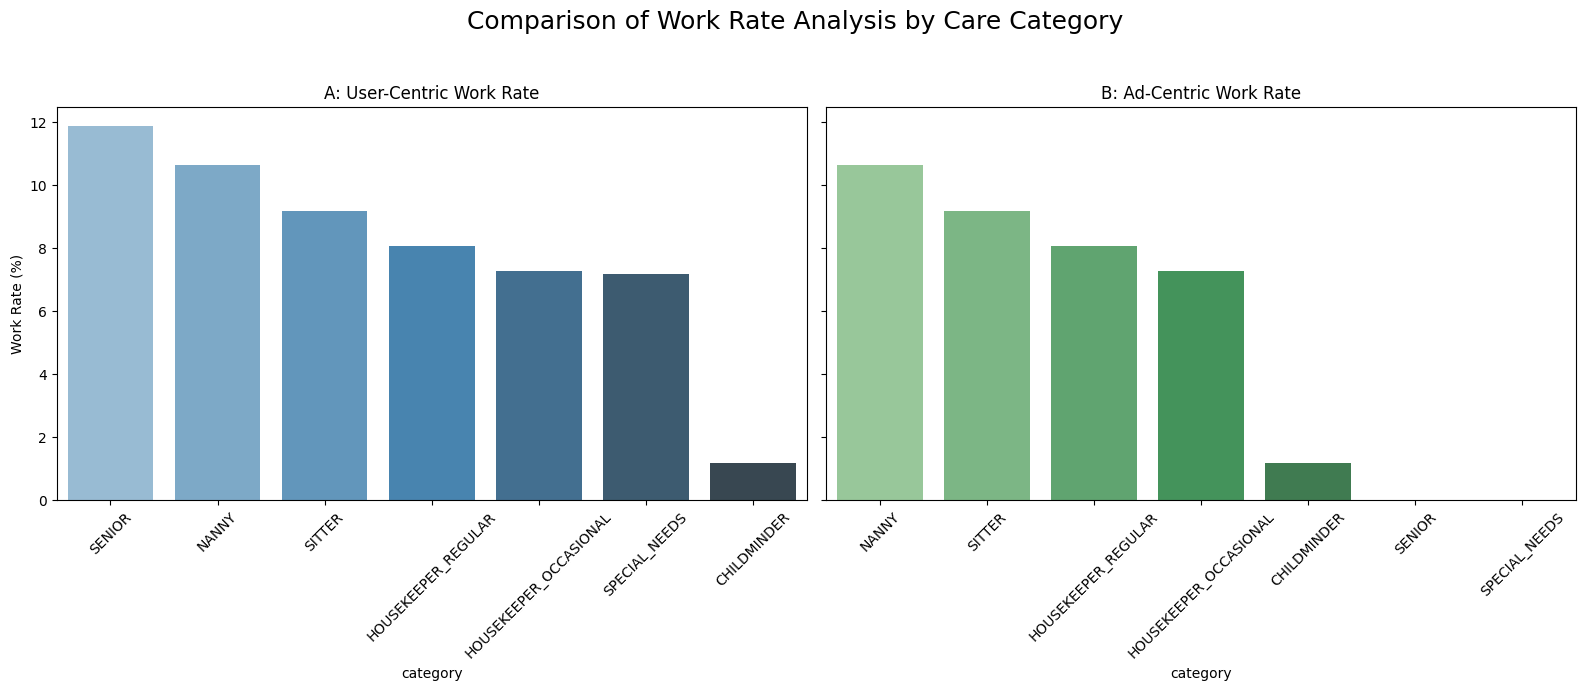


--- Work Rate in Paris vs. Marseille ---
              User_Count  Work_Rate_Percent
address_city                               
Paris               3115              12.62
Marseille            543               7.92


In [16]:
print("\n\n" + "="*60)
print("Analysis 3: Targeted Descriptive Analyses")
print("="*60)

# --- Care Category Analysis A vs B ---
print("\n--- Work Rate by Care Category ---")

# Analysis A: User-Centric ("Of users with a 'NANNY' ad, what % have worked AT ALL?")
user_categories = df_ads_master[['user_id', 'category']].drop_duplicates().dropna()
df_analysis_A = df_users_master.merge(user_categories, on='user_id', how='inner')
user_centric_analysis = df_analysis_A.groupby('category')['has_worked'].agg(
    Work_Rate_Percent=lambda x: x.mean() * 100, User_Count='count'
).sort_values('Work_Rate_Percent', ascending=False)

# Analysis B: Ad-Centric ("Of all 'NANNY' ads, what % have worked hours?")
ad_centric_analysis = df_ads_master.groupby('category')['ad_has_worked'].agg(
    Work_Rate_Percent=lambda x: x.mean() * 100, Ad_Count='count'
).sort_values('Work_Rate_Percent', ascending=False)

print("\n--- Analysis A (User-Centric) ---")
print(user_centric_analysis.round(2))
print("\n--- Analysis B (Ad-Centric) ---")
print(ad_centric_analysis.round(2))

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Comparison of Work Rate Analysis by Care Category', fontsize=18)
sns.barplot(ax=axes[0], x=user_centric_analysis.index, y=user_centric_analysis['Work_Rate_Percent'], palette='Blues_d')
axes[0].set_title('A: User-Centric Work Rate')
axes[0].set_ylabel('Work Rate (%)')
axes[0].tick_params(axis='x', rotation=45)
sns.barplot(ax=axes[1], x=ad_centric_analysis.index, y=ad_centric_analysis['Work_Rate_Percent'], palette='Greens_d')
axes[1].set_title('B: Ad-Centric Work Rate')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Geolocation: Paris vs. Marseille ---
print("\n--- Work Rate in Paris vs. Marseille ---")
cities_to_analyze = ['Paris', 'Marseille']
df_cities = df_users_master[df_users_master['address_city'].isin(cities_to_analyze)]
if not df_cities.empty:
    city_analysis = df_cities.groupby('address_city')['has_worked'].agg(
        User_Count='count', Work_Rate_Percent=lambda x: x.mean() * 100
    ).reindex(cities_to_analyze)
    print(city_analysis.round(2))
else:
    print("No users with primary ads in Paris or Marseille.")

### 4: Unsupervised Learning: PCA and Clustering



Analysis 4: Unsupervised Learning (PCA & Clustering)

--- Principal Component Analysis (PCA) ---


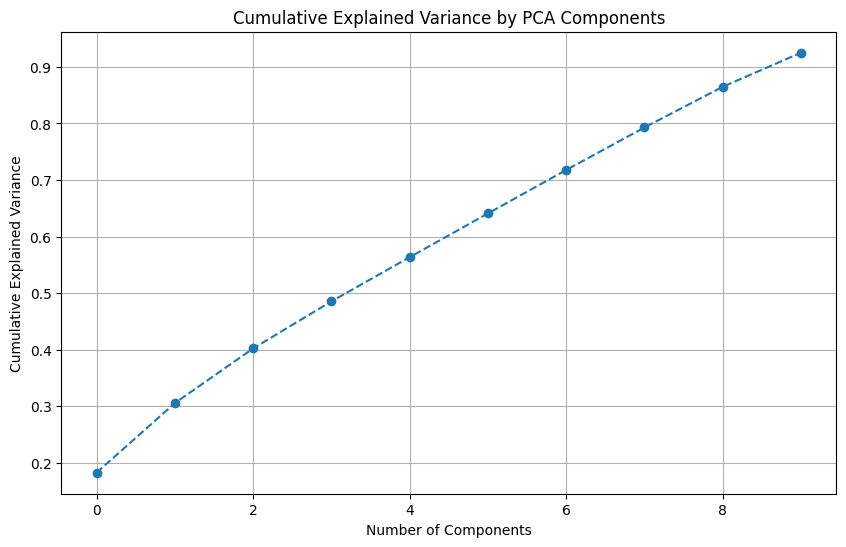

Variance explained by first 2 components: 30.56%


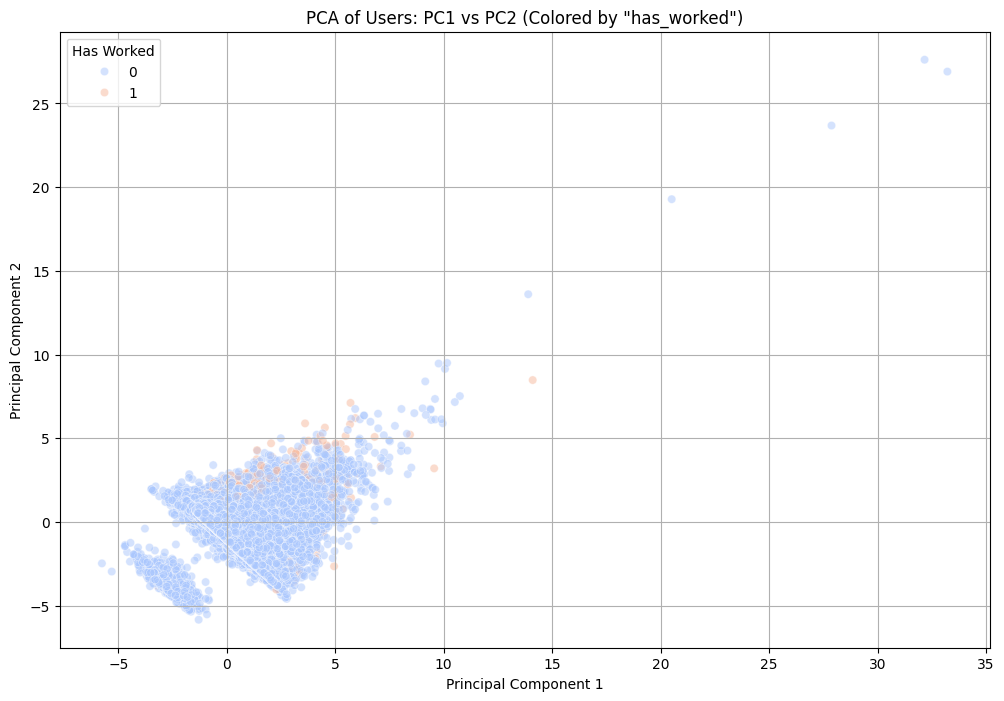


--- Clustering with DBSCAN ---


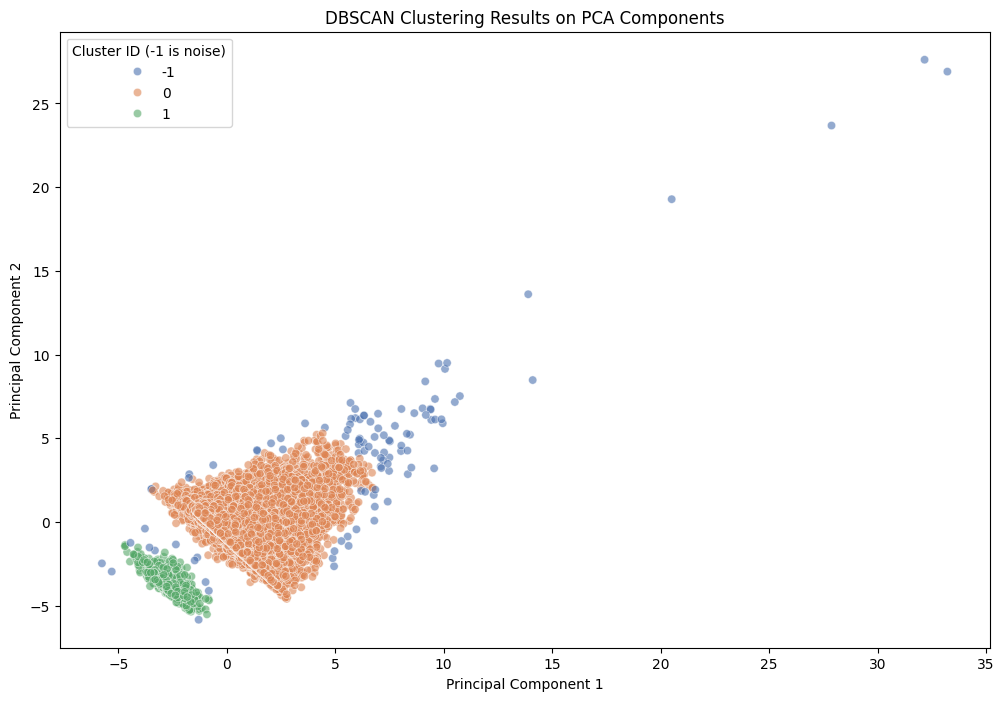

Cluster distribution:
 0    36635
 1      848
-1      104
Name: count, dtype: int64


In [17]:
print("\n\n" + "="*60)
print("Analysis 4: Unsupervised Learning (PCA & Clustering)")
print("="*60)

# Prepare data - only numeric features, excluding IDs and targets
df_numeric = df_users_master.select_dtypes(include=np.number).copy()
features_to_drop = [
    'user_id', 'has_worked', 'total_worked_hours', 'ad_creation_year',
    'address_latitude', 'address_longitude'
]
df_numeric.drop(columns=[col for col in features_to_drop if col in df_numeric.columns], inplace=True)
df_numeric.fillna(df_numeric.median(), inplace=True)

# Standardize data for PCA and Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# --- PCA ---
print("\n--- Principal Component Analysis (PCA) ---")
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])
df_pca['has_worked'] = df_users_master['has_worked'] # Add target for coloring

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()
print(f"Variance explained by first 2 components: {sum(pca.explained_variance_ratio_[:2]):.2%}")

# Plot PC1 vs PC2
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='has_worked', data=df_pca, alpha=0.5, palette='coolwarm')
plt.title('PCA of Users: PC1 vs PC2 (Colored by "has_worked")')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Has Worked')
plt.grid(True)
plt.show()

# --- Clustering (DBSCAN) ---
# DBSCAN is sensitive to parameters. These are starting points.
print("\n--- Clustering with DBSCAN ---")
# Using the first two principal components as input for clustering
dbscan = DBSCAN(eps=0.5, min_samples=10) # eps might need tuning
clusters = dbscan.fit_predict(df_pca[['PC1', 'PC2']])
df_pca['cluster'] = clusters

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='deep', alpha=0.6)
plt.title('DBSCAN Clustering Results on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID (-1 is noise)')
plt.show()

print("Cluster distribution:")
print(pd.Series(clusters).value_counts())

### 5: Predictive Modeling Part 1: Decision Tree



Analysis 5: Decision Tree for 'has_worked'


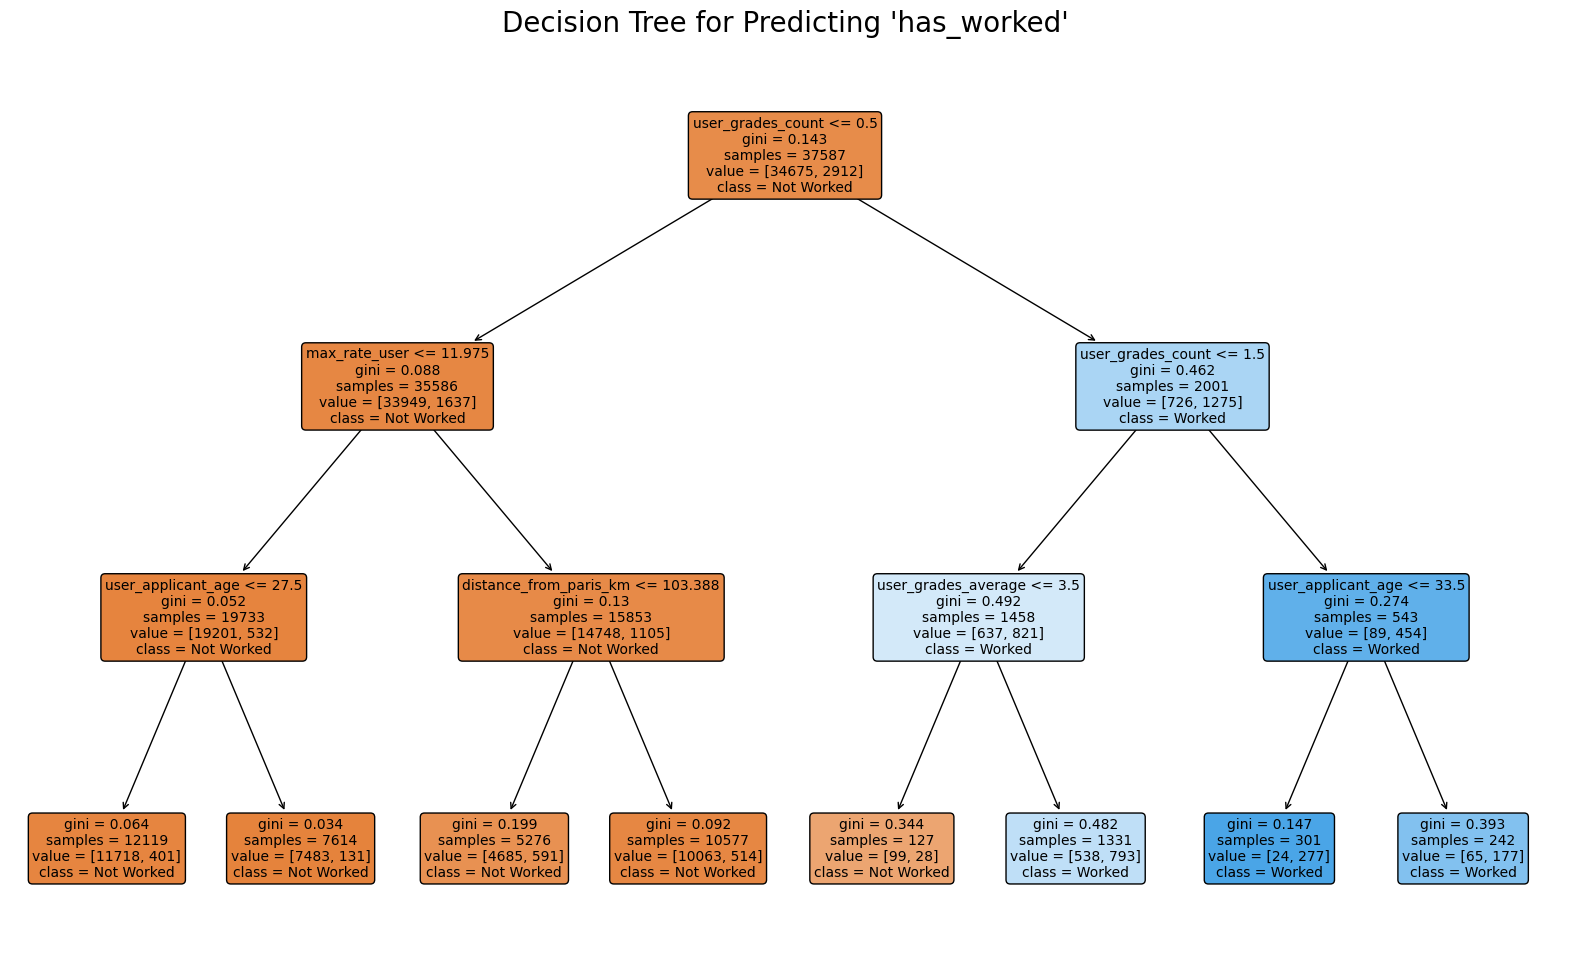

In [18]:
print("\n\n" + "="*60)
print("Analysis 5: Decision Tree for 'has_worked'")
print("="*60)

# Prepare data
df_model = df_users_master.select_dtypes(include=np.number).copy()
df_model.drop(columns=['user_id', 'total_worked_hours', 'ad_creation_year'], inplace=True, errors='ignore')
df_model.fillna(df_model.median(), inplace=True)

X = df_model.drop('has_worked', axis=1)
y = df_model['has_worked']

# Train a simple Decision Tree
# max_depth=3 makes it easy to visualize
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_classifier.fit(X, y)

# Visualize the tree
plt.figure(figsize=(20, 12))
plot_tree(dt_classifier,
          feature_names=X.columns,
          class_names=['Not Worked', 'Worked'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree for Predicting 'has_worked'", fontsize=20)
plt.show()

### 6: Predictive Modeling Part 2: SHAP for Both Targets



Analysis 6: SHAP Feature Importance

--- Running SHAP Analysis for Target: 'total_worked_hours' ---
  Excluded 0 columns with suffix '_confidence'.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1452
[LightGBM] [Info] Number of data points in the train set: 30069, number of used features: 16
[LightGBM] [Info] Start training from score 17.112641
  SHAP Summary for 'total_worked_hours':


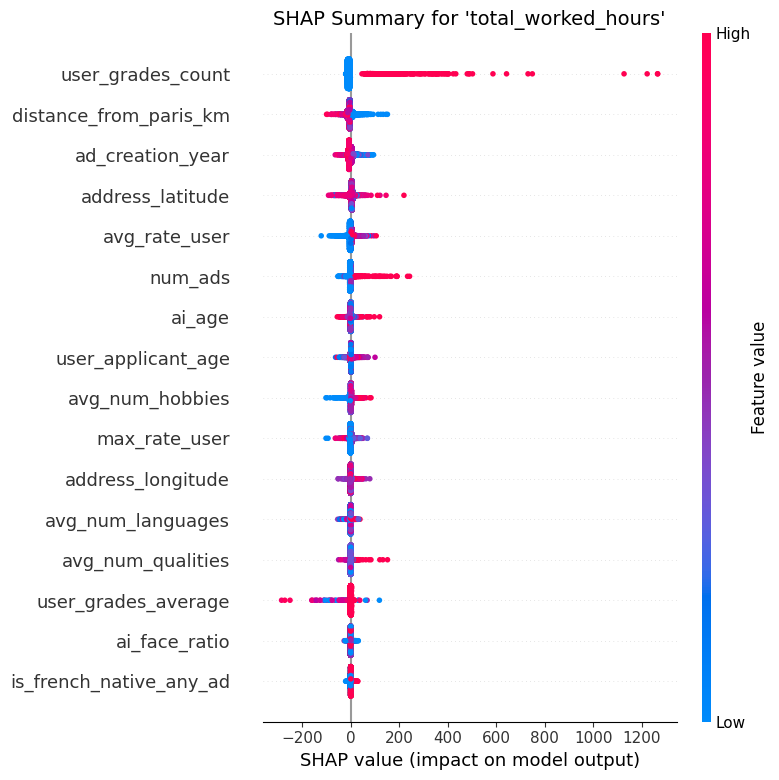


--- Running SHAP Analysis for Target: 'has_worked' ---
  Excluded 0 columns with suffix '_confidence'.
[LightGBM] [Info] Number of positive: 2320, number of negative: 27749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1452
[LightGBM] [Info] Number of data points in the train set: 30069, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077156 -> initscore=-2.481633
[LightGBM] [Info] Start training from score -2.481633
  SHAP Summary for 'has_worked':


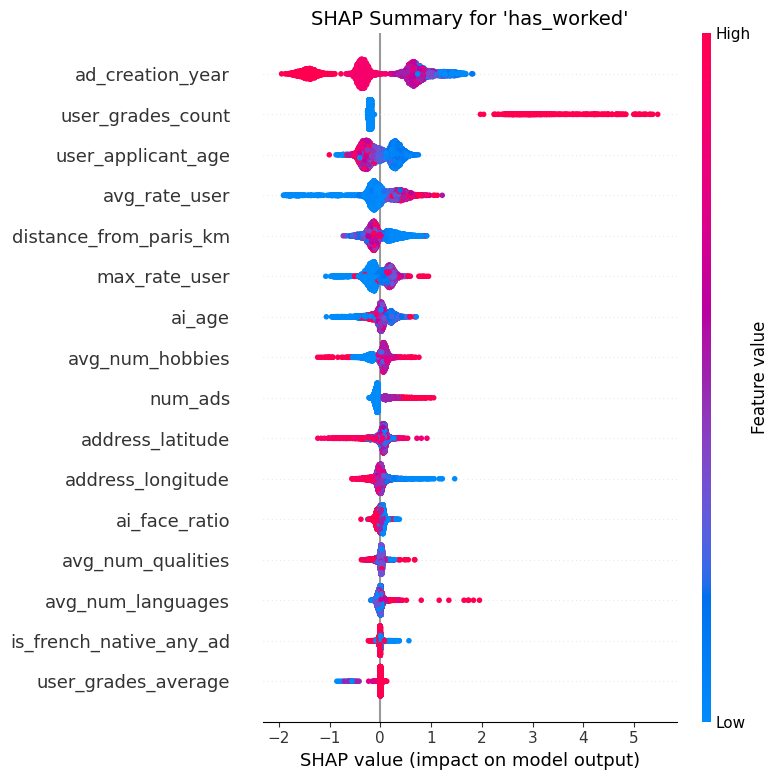

In [19]:
def run_shap_analysis(df_master, target_variable, model_type='regressor', exclude_suffix=None):
    """Prepares data, trains a model, and generates SHAP plots for a given target."""
    print(f"\n--- Running SHAP Analysis for Target: '{target_variable}' ---")
    
    # Prepare data
    df_model = df_master.select_dtypes(include=np.number).copy()
    
    # Exclude columns by suffix if requested
    if exclude_suffix:
        cols_to_drop = [col for col in df_model.columns if col.endswith(exclude_suffix)]
        df_model.drop(columns=cols_to_drop, inplace=True)
        print(f"  Excluded {len(cols_to_drop)} columns with suffix '{exclude_suffix}'.")

    # Define other target and ID columns to drop
    other_targets = ['has_worked', 'total_worked_hours']
    other_targets.remove(target_variable)
    ids_to_drop = ['user_id']
    
    df_model.drop(columns=other_targets + ids_to_drop, inplace=True, errors='ignore')
    df_model.fillna(df_model.median(), inplace=True)

    X = df_model.drop(target_variable, axis=1)
    y = df_model[target_variable]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    if model_type == 'regressor':
        model = lgb.LGBMRegressor(random_state=42)
    else: # classifier
        model = lgb.LGBMClassifier(random_state=42)
    
    model.fit(X_train, y_train)
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    # Visualize SHAP summary
    print(f"  SHAP Summary for '{target_variable}':")
    
    # The beeswarm plot is great for detail
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP Summary for '{target_variable}'", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- Run SHAP for both target variables ---
if not df_users_master.empty:
    print("\n\n" + "="*60)
    print("Analysis 6: SHAP Feature Importance")
    print("="*60)
    
    # Target 1: total_worked_hours (Regression)
    run_shap_analysis(df_users_master, target_variable='total_worked_hours', model_type='regressor', exclude_suffix='_confidence')
    
    # Target 2: has_worked (Classification)
    run_shap_analysis(df_users_master, target_variable='has_worked', model_type='classifier', exclude_suffix='_confidence')